In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings(action='ignore')

# Chargement et préparation des données

In [2]:
raw_data = pd.read_csv('mushrooms.csv')
raw_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Ce jeu de données contient des entrées correspondants à des caractéristiques de champignons (surface, couleur, etc), ainsi qu'un indicateur 'class' de comestibilité ('p' pour poisonous, 'e' pour edible).

Première chose, encoder nos données en données chiffres plutôt que des lettres

In [3]:
labelencoder=LabelEncoder()
for col in raw_data.columns:
    raw_data[col] = labelencoder.fit_transform(raw_data[col])
raw_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


On sépare notre jeu de donnée de manière classique entre données d'entraînement et données de test.  

In [4]:
# On récupère les features d'un côté...
X = raw_data.iloc[:,1:23]

# et les labels de l'autre
y = raw_data.iloc[:,0] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Régression logistique

## Régression logistique classique

Par défaut, la fonction LogisticRegression() de scikit-learn utilise la pénalité l2, et une régularisation à 1 (paramètre C est l'inverse de la régularisation et est paramétré à 1 par défaut).

In [5]:
lr = LogisticRegression()

lr.fit(X_train,y_train)

# On récupère la prédiction de la valeur positive
y_prob = lr.predict_proba(X_test)[:,1] 

# On créé un vecteur de prédiction à partir du vecteur de probabilités
y_pred = np.where(y_prob > 0.5, 1, 0) 

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.9788337571377588


La sortie donne un aire sous la courbe de 0.982.
Dessinons cette courbe :

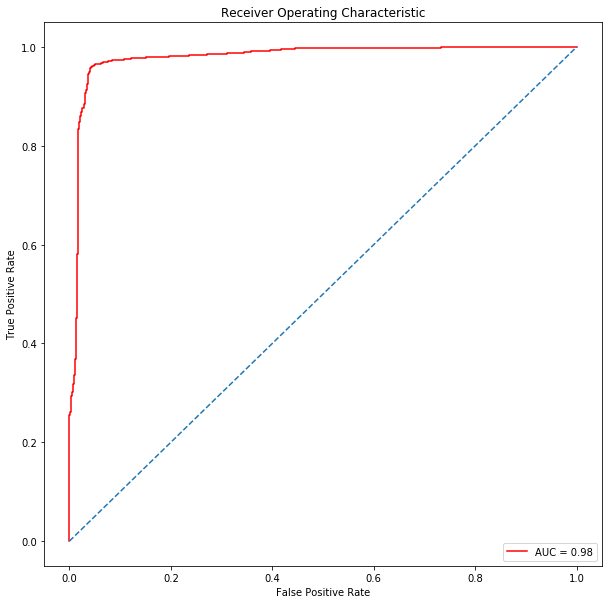

In [6]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Régression logistique avancée

On peut maintenant essayer de tuner cette régression logistique en testant plusieurs paramètres, à l'aide de la fonctionGridSearchCV qui effectue aussi en passant une validation croisée.

In [7]:
lr = LogisticRegression()
params = {'C': np.logspace(-3, 3, 7) , 'penalty':['l1','l2'] }

lr_gs = GridSearchCV(lr, params, cv=10)
lr_gs.fit(X_train, y_train)

print(lr_gs.best_params_)

{'C': 1000.0, 'penalty': 'l2'}


Comme pour la régression linéaire, la différences entre un paramètre de régularisation de norme 1 ou 2 est que celui de norme 1 effectue en même temps une sélection des variables (parmi celles qui sont corrélées) en mettant leur poids à zéro.

On peut évaluer notre modèle de la même manière que pour la régression logistique classique, avec une AUC : 

In [8]:
# On récupère la prédiction de la valeur positive
y_prob = lr_gs.predict_proba(X_test)[:,1] 

# On créé un vecteur de prédiction à partir du vecteur de probabilités
y_pred = np.where(y_prob > 0.5, 1, 0) 

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.9902787071734476


# SVM linéaire

On peut maintenant tester les performance du SVM Linéaire. 

In [14]:
svm = LinearSVC()

params = { 'C': np.logspace(-3, 3, 7) }

gs_svm = GridSearchCV(svm, params, cv=10)
gs_svm.fit(X_train, y_train)

print(gs_svm.best_params_)

{'C': 1.0}


On peut maintenant passer à l'évaluation

In [17]:
# On récupère la prédiction de la valeur positive
y_pred = gs_svm.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.9478480772662384


Le SVM Linéaire possède des performances similaires à la régression logistique. 

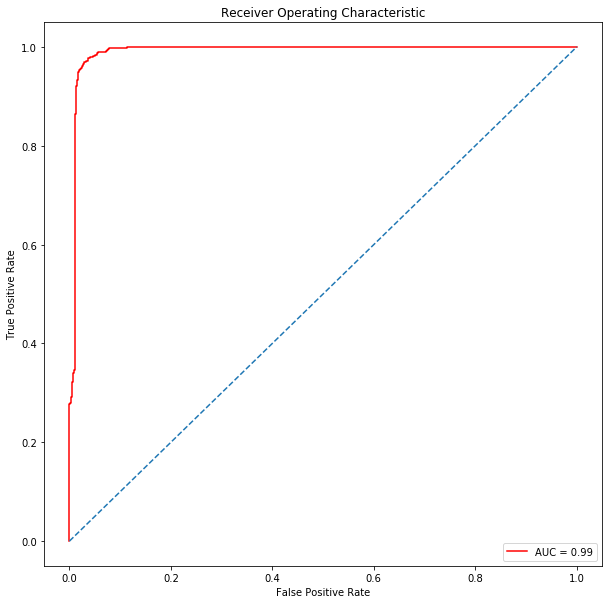

In [11]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()